# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs
## Part : Optimal transport
## Chapter : The Monge-Ampere equation

This notebook presents a series of methods for numerically solving the Monge-Ampere equation
$$
    f(x) - \det(\nabla^2 u(x)) = 0,
$$
among convex functions, with Dirichlet boundary conditions. 
The function $f$ is assumed to be strictly positive.
For that purpose, we rely on the monotone and consistent MA-LBR numerical scheme (Monge-Ampere using Lattice Basis Reduction), and some variants.

**References.**

The MA-LBR scheme was first introduced in:
* Benamou, J.-D., Collino, F., & Mirebeau, J.-M. (2016). Monotone and Consistent discretization of the Monge-Ampere operator. Mathematics of Computation, 85(302), 2743–2775.

**Reformulation as an extremal operator.**
The starting point of these methods is to observe that, for a positive definite $d \times d$ matrix $M$
$$
    d ({\rm det} M)^\frac 1 d = \inf_{{\rm det} D = 1} {\rm tr}(D M),
$$
where, implicitly, the optimization variable $D$ is also assumed to be a symmetric positive definite matrix.

If $M = \nabla^2 u$ is a hessian matrix, then the l.h.s. is (a multiple of a power of) the Monge-Ampere operator, while the r.h.s. is an infimum of second order linear operators, which can be discretized using monotone finite differences.

**Discretization strategy**
The chosen finite difference scheme for the linear operator is described in 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)
Since 


[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Naive non-monotone discretization (purposedly fails)](#1.-Naive-non-monotone-discretization-(purposedly-fails))
  * [2. The MA-LBR scheme](#2.-The-MA-LBR-scheme)
    * [2.1 First implementation](#2.1-First-implementation)
    * [2.2 Optimized implementation](#2.2-Optimized-implementation)
  * [3. Uniformly elliptic scheme](#3.-Uniformly-elliptic-scheme)
    * [3.1 First implementation](#3.1-First-implementation)
    * [3.2 Optimized implementation](#3.2-Optimized-implementation)
  * [3 Validation](#3-Validation)
    * [3.1 Comparison with a sampling based scheme](#3.1-Comparison-with-a-sampling-based-scheme)
    * [3.2 The monotone and consistent schemes have identical solutions](#3.2-The-monotone-and-consistent-schemes-have-identical-solutions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.append("..") # Allow imports from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('MongeAmpere','NonDiv'))

In [3]:
from NumericalSchemes import Selling
from NumericalSchemes import Domain
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import AutomaticDifferentiation as ad

In [4]:
import numpy as np
from matplotlib import pyplot as plt

Some utility functions

In [5]:
newton_root = ad.Optimization.newton_root
stop    = ad.Optimization.stop_default
damping = ad.Optimization.damping_default 

In [6]:
def reload_packages():
    import importlib
    Selling = importlib.reload(sys.modules['NumericalSchemes.Selling'])
    Domain = importlib.reload(sys.modules['NumericalSchemes.Domain'])
    lp = importlib.reload(sys.modules['NumericalSchemes.LinearParallel'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.reload_submodules()

In [7]:
figSaveDir = None #"Figures/MongeAmpere/"

## 1. Naive non-monotone discretization (purposedly fails)

We present a naive, non-monotone discretization of the addressed problem. This scheme can be used to check that a numerical solution (produced by other means) is correct, or to construct synthetic examples. However, using it to solve the PDE is usually bound to fail. 

The naive scheme is based on a reconstruction of the Hessian matrix of the form
$$
    \begin{pmatrix}
        D^h_{00} u(x) & D^h_{01} u(x)\\
        D^h_{01} u(x) & D^h_{11} u(x)
    \end{pmatrix},
$$
where $D_{00}$, $D_{01}$ and $D_{11}$ are finite-difference operators. Namely
$$
    D^h_{00} u(x) := \frac{u(x_0+h,x_1)-2 u(x_0,x_1) + u(x_0-h,x_1)}{h^2},
$$
likewise for $D^h_{11} u(x)$, and finally
$$
    D^h_{01} u(x) := \frac{u(x_0+h,x_1+h)-u(x_0-h,x_1+h)-u(x_0+h,x_1-h)+h(x_0-h,x_1-h)}{4 h^2}.
$$

In [8]:
def SchemeNonMonotone(u,f,bc):
    # Compute the hessian matrix of u
    uxx = bc.Diff2(u,(1,0))
    uyy = bc.Diff2(u,(0,1))
    uxy = 0.25*(bc.Diff2(u,(1,1)) - bc.Diff2(u,(1,-1)))
    
    # Numerical scheme
    det = uxx*uyy-uxy**2
    residue = f - det
    
    # Boundary conditions
    return ad.where(bc.interior,residue,u-bc.grid_values)

We next choose some problem parameters

In [9]:
# Create the domain
aX0 = np.linspace(-1,1,100); aX1=aX0;
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

# Set the boundary conditions 
gridscale = aX0[1]-aX0[0]
bc_square = Domain.Dirichlet(Domain.Box([[-1,1],[-1,1]]),0.,X)
bc_convex = Domain.Dirichlet(Domain.Union((Domain.Ball(),Domain.Box())), 0., X)
bc_concave = Domain.Dirichlet(Domain.Complement(Domain.Ball(),Domain.Box()), 0., X)

# Choose the PDE parameters
f=1.

The following quadratic function, often shifted by a constant value, will be used as a guess for the numerical methods.

In [10]:
quadratic = X[0]**2+X[1]**2

The naive and non-monotone discretization scheme is consistent, but lacks any other sort of theoretical guarantees. 

**In general, attempts to solve numerically the non-monotone scheme will fail. This is expected behavior**

The non-monotone scheme may nevertheless work for some specific gentle problem instances (with a smooth solution), a careful initialization, and a bit of luck. This is the case below.

<!---This is the case below, where we solve the same problem as above, but with a different handling of the boundary conditions: they are imposed implicitly by the padding values used in the finite differences.--->

Iteration: 1  Residue norm: 1225.4294894654133
Iteration: 2  Residue norm: 306.0919194323183
Iteration: 3  Residue norm: 76.26003650874995
Iteration: 4  Residue norm: 18.809123287336305
Iteration: 5  Residue norm: 4.457432515643999
Iteration: 6  Residue norm: 0.9079346172675689
Iteration: 8  Residue norm: 0.002566380867047968
Iteration: 10  Residue norm: 2.4522606167920458e-12
Target residue reached. Terminating.


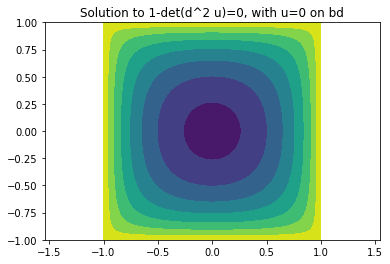

In [11]:
params = (f,bc_square)
solution_non_monotone = newton_root(SchemeNonMonotone,quadratic-2,params) 

plt.axis('equal'); plt.title("Solution to 1-det(d^2 u)=0, with u=0 on bd")
plt.contourf(*X,solution_non_monotone);

However, the non-monotone scheme fails even on a simple convex domain.

Iteration: 1  Residue norm: 2248930.68557337
Iteration: 2  Residue norm: 835538.8567515145
Iteration: 3  Residue norm: 208871.1066733644
Iteration: 4  Residue norm: 52209.443003330256
Iteration: 5  Residue norm: 11178846.58747576
Iteration: 6  Residue norm: 3025743.428703135
Iteration: 8  Residue norm: 2055892.3846235792
Iteration: 10  Residue norm: 128453.5750044985
Iteration: 12  Residue norm: 84225.35166409618
Iteration: 14  Residue norm: 35394577.90229907
Iteration: 16  Residue norm: 2527625.104945321
Iteration: 20  Residue norm: 168900150.49461734
Iteration: 24  Residue norm: 135332026.51906884
Iteration: 28  Residue norm: 528635.0369884853
Iteration: 32  Residue norm: 1904413110.8333597
Iteration: 36  Residue norm: 283357749.9265231
Iteration: 40  Residue norm: 1106849.7320526147
Iteration: 44  Residue norm: 28266.65745730624
Iteration: 48  Residue norm: 35555.02694419301
Iteration: 50  Residue norm: 33178676.9433007
Max iterations exceeded. Aborting.


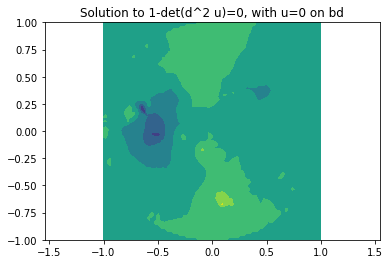

In [51]:
params = (f,bc_convex)
newton_root(SchemeNonMonotone,quadratic-2,params,
            stop = ad.Optimization.stop_default(raise_on_abort=False)) 

## 2. The MA-LBR scheme

The MA-LBR scheme is a monotone and consistent discretization of the Monge-Ampere operator. It takes the form:
$$
    \Lambda u(x) := \inf_{(e_0,e_1,e_2) \in S} H( \Delta_{e_0}^h u(x), \Delta_{e_1}^h u(x), \Delta_{e_2}^h u(x)).
$$
We denoted by $S$ a family of superbases of $Z^2$, which is a parameter to the scheme that must be chosen, see below. 
Superbases are triplets $(e_0,e_1,e_2)$ of vectors $e_0,e_1,e_2 \in Z^2$ with integer coordinates.

We denoted second order finite differences, in a direction $e\in Z^2$ by 
$$
    \Delta_e^h u(x) := \frac{u(x+h e) -2 u(x) +u(x+he)} {h^2}.
$$
The scheme also features a three argument function $H$, defined as follows: $H(a,b,c) := H_0(a_+,b_+,c_+)$, where 
$$
    H_0(a,b,c) :=
    \begin{cases}
        a b \quad \text{ if }\ a+b < c, \text{ and likewise permuting } a,b,c\\
        \frac 1 2 (a b+b c+c a) - \frac 1 4 (a^2+b^2+c^2)\quad \text{ otherwise}.
    \end{cases}
$$


**Convexity of the solution, and ellipticity of the PDE and numerical scheme.**

The Monge-Ampere equation imposes, as a constraint, that the solution $u$ be convex. The ellipticity of the Monge-Ampere operator degenerates as $\det(\nabla^2 u) \to 0$, which means that $u$ looses convexity.

A similar issue arises with the MA-LBR scheme. It is strictly elliptic only as long as 
$$
    \Lambda u(x) > 0,
$$
which is a discrete counterpart of convexity. 

**Damping of the Newton method.**
We need to guarantee that, along the iterations, the numerical scheme ellipticity is preserved. 
A first requirement for this is to choose a strictly convex initialization, for instance the quadratic function $u(x) = \|x\|^2/2$.

For this reason, we also resort to a damped Newton method. The default behavior is to define
$$
    u_{n+1} = u_n + 2^{-k_n} d_n,
$$
where $d_n$ is the Newton descent direction, and $k_n$ is the least integer such that 
$$
    \Lambda u_{n+1}(x) \geq f(x)/2,
$$
at all discretization points $x$.
(Recall that the r.h.s $f$ is assumed to be strictly positive.)

We assume, for simplicity, that this condition holds at initialization. Otherwise a threshold lower than $f/2$ could be used.

### 2.1 First implementation

In [13]:
def MALBR_H(d2u):
    a,b,c = ad.sort(np.maximum(0.,d2u), axis=0)

    # General formula, handling infinite values separately
    A,B,C = (ad.where(e==np.inf,0.,e) for e in (a,b,c))
    result = 0.5*(A*B+B*C+C*A)-0.25*(A**2+B**2+C**2)
    
    pos_inf = np.logical_or.reduce(d2u==np.inf)    
    result[pos_inf]=np.inf
    
    pos_ineq = a+b<c
    result[pos_ineq] = (A*B)[pos_ineq]
        
    return result
    
def SchemeMALBR(u,SB,f,bc):
    # Compute the finite differences along the superbase directions
    d2u = bc.Diff2(u,SB)
    d2u[...,bc.not_interior] = 0. # Replace NaNs with arbitrary values to silence warnings
    
    # Numerical scheme
    residue = f-MALBR_H(d2u).min(axis=0)
    
    # Boundary conditions
    return ad.where(bc.interior,residue,u-bc.grid_values)

We next implement the test used to select the damping parameter, as announced. 

In [14]:
def InvalidMALBR(u,SB,f,bc):
    residue = SchemeMALBR(u,SB,f,bc)
    return np.any(residue[bc.interior]>=f/2)

We next choose a family of superbases. The scheme is (second order) consistent while the condition number of the hessian of $u$ remains below the given bound. Beyond that, a consistency defect is introduced.

In [15]:
SB0 = Selling.SuperbasesForConditioning(5)
SB1 = Selling.SuperbasesForConditioning(15)
SB2 = Selling.SuperbasesForConditioning(30)

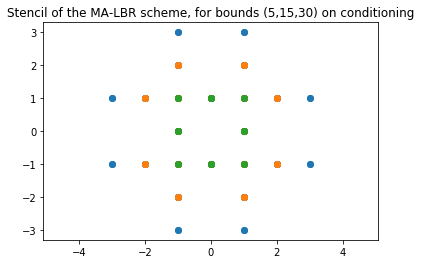

In [16]:
plt.axis('equal'); plt.title('Stencil of the MA-LBR scheme, for bounds (5,15,30) on conditioning')
def stencil(SB): return np.stack((SB,-SB),axis=2)[:,:]
plt.scatter(*stencil(SB2));plt.scatter(*stencil(SB1));plt.scatter(*stencil(SB0));

In [17]:
#bc2_grid_values = np.zeros(bc.shape); bc2_grid_values[1:-1,1:-1]=np.nan
#bc2 = Domain.MockDirichlet(bc2_grid_values,gridscale,padding=np.inf)

The initial guess is chosen to be in the ellipticity domain of the operator.

In [18]:
InvalidMALBR(quadratic-2.,SB0,f,bc_convex)

False

In [19]:
%%time
# This damping rule cuts the step size in half until the MALBR validity criterion is met
dampingMALBR = damping(criterion=InvalidMALBR)

params = (SB0,f,bc_convex)
solution_MALBR = newton_root(SchemeMALBR,quadratic-2.,params,damping=dampingMALBR)

Iteration: 1  Residue norm: 2653538.1251855316
Iteration: 2  Residue norm: 1492615.1329154281
Iteration: 3  Residue norm: 1142783.4455132973
Iteration: 4  Residue norm: 874943.5598453886
Iteration: 5  Residue norm: 669878.6473794987
Iteration: 6  Residue norm: 512875.82377066754
Iteration: 8  Residue norm: 162277.01845434026
Iteration: 10  Residue norm: 10142.001152535076
Iteration: 12  Residue norm: 1426.0157807545588
Iteration: 14  Residue norm: 835.8766663110767
Iteration: 16  Residue norm: 359.91081163056964
Iteration: 20  Residue norm: 76.52689110514798
Iteration: 24  Residue norm: 2.6047952012999795
Iteration: 28  Residue norm: 1.020487250258384e-09
Target residue reached. Terminating.
CPU times: user 36.8 s, sys: 3.52 s, total: 40.4 s
Wall time: 10.3 s


The last Newton steps, close to the solution, equal one. In contrast, a stong damping is applied in some of the first. 

In [20]:
np.array(dampingMALBR.steps)

array([0.5  , 0.5  , 0.25 , 0.25 , 0.25 , 0.25 , 0.5  , 0.5  , 1.   ,
       1.   , 1.   , 0.5  , 0.25 , 0.25 , 0.25 , 0.5  , 0.125, 0.25 ,
       0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 1.   , 1.   , 1.   , 1.   ,
       1.   ])

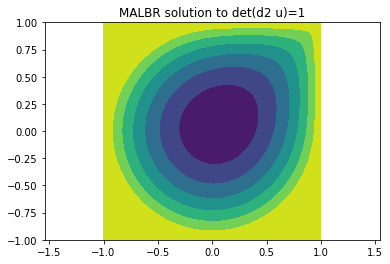

In [21]:
plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(*X,solution_MALBR);

The method also works for the square domain.

Iteration: 1  Residue norm: 2757.303780227434
Iteration: 2  Residue norm: 1550.9088719682768
Iteration: 3  Residue norm: 1187.395804288215
Iteration: 4  Residue norm: 909.0813228879124
Iteration: 5  Residue norm: 695.9969226543908
Iteration: 6  Residue norm: 532.8542052996927
Iteration: 8  Residue norm: 168.48077525275585
Iteration: 10  Residue norm: 10.09917542054336
Iteration: 12  Residue norm: 0.34715953318112724
Iteration: 14  Residue norm: 0.00010333129620221371
Iteration: 15  Residue norm: 2.6176678602496395e-09
Target residue reached. Terminating.
CPU times: user 19.6 s, sys: 1.87 s, total: 21.5 s
Wall time: 5.44 s


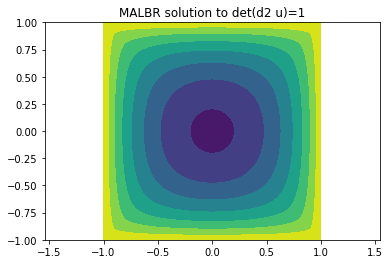

In [22]:
%%time
params = (SB0,f,bc_square)
solution_MALBR = newton_root(SchemeMALBR,quadratic-2.,params,damping=dampingMALBR)

plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(*X,solution_MALBR);

And with the non-convex domain.

Iteration: 1  Residue norm: 1179350.0556284206
Iteration: 2  Residue norm: 902939.8707116165
Iteration: 3  Residue norm: 691313.3228837634
Iteration: 4  Residue norm: 388863.6815995881
Iteration: 5  Residue norm: 218735.7583724516
Iteration: 6  Residue norm: 54683.689474750274
Iteration: 8  Residue norm: 3417.4180175538427
Iteration: 10  Residue norm: 1081.1948045851855
Iteration: 12  Residue norm: 633.7489748133308
Iteration: 14  Residue norm: 272.86948080544767
Iteration: 16  Residue norm: 159.9235439869186
Iteration: 20  Residue norm: 6.335453774746195
Iteration: 24  Residue norm: 9.313143518596689e-07
Iteration: 25  Residue norm: 1.3201884030422661e-10
Target residue reached. Terminating.
CPU times: user 22.6 s, sys: 1.74 s, total: 24.3 s
Wall time: 6.12 s


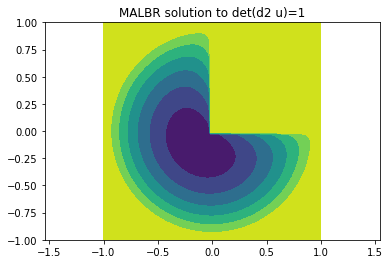

In [46]:
%%time
params = (SB0,f,bc_concave)
solution_MALBR = newton_root(SchemeMALBR,quadratic-2.,params,damping=dampingMALBR)

plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(*X,solution_MALBR);

### 2.2 Optimized implementation

In the course of the Newton method, the AD-LBR scheme is evaluated on sparse AD variables. In this regard, two features of the scheme yield optimization opportunities:
* *Minimization over the superbases.* Using the envelope theorem, we find the minimizer using ordinary arrays without AD information, and then provide this oracle information in a second pass involving AD information.
* *Complex non-linear function $H$.* We can take advantage of dense and sparse AD composition, to efficiently evaluate $H$.

**Important: other optimization opportunities.**
Our main intent in this subsection is to illustrate advanced AD techniques. There may be other optimization opportunities.

In [24]:
def SchemeMALBR_OptInner(u,SB,bc,oracle=None):
    # If the active superbases are known, then take only these
    if not(oracle is None):
        SB = np.take_along_axis(SB,np.broadcast_to(oracle,SB.shape[:2]+(1,)+oracle.shape),axis=2)
                
    d2u = bc.Diff2(u,SB)
    d2u[...,bc.not_interior] = 0. # Placeholder value to silent NaN warnings
    # Evaluate the complex non-linear function using dense - sparse composition
    result = ad.apply(MALBR_H,d2u,shape_bound=u.shape)
    
    return ad.min_argmin(result,axis=0)

def SchemeMALBR_Opt(u,SB,f,bc):
    
    # Evaluate using the envelope theorem
    result,_ = ad.apply(SchemeMALBR_OptInner, u,bc.as_field(SB),bc, envelope=True)
        
    # Boundary conditions
    return ad.where(bc.interior, f - result, u-bc.grid_values)

We can afford more superbases, taking `SB2` instead of `SB0`, thanks to the optimizations. Replace `SchemeMALBR_Opt` with `SchemeMALBR` to see the computation time difference.

In [25]:
ad.reload_submodules()

In [26]:
%%time
params = (SB2,f,bc_convex)
solution_MALBR = newton_root(SchemeMALBR_Opt,quadratic-2.,params,damping=dampingMALBR) 

Iteration: 1  Residue norm: 731500.8114397213
Iteration: 2  Residue norm: 411469.13168804685
Iteration: 3  Residue norm: 231451.3041619493
Iteration: 4  Residue norm: 130191.26740763718
Iteration: 5  Residue norm: 73232.48781317273
Iteration: 6  Residue norm: 41193.16714633133
Iteration: 8  Residue norm: 5792.304927436444
Iteration: 10  Residue norm: 813.8969293957032
Iteration: 12  Residue norm: 255.59643921476368
Iteration: 14  Residue norm: 149.3317718444343
Iteration: 16  Residue norm: 87.0918108008472
Iteration: 20  Residue norm: 21.187337097121592
Iteration: 24  Residue norm: 3.7011587768577066
Iteration: 28  Residue norm: 0.020089320984696957
Iteration: 31  Residue norm: 1.1883827255587676e-12
Target residue reached. Terminating.
CPU times: user 49.8 s, sys: 3.88 s, total: 53.7 s
Wall time: 13.6 s


If we use the same set of superbases, then the optimized and non-optimized versions yield an identical result, up to machine precision, iteration after iteration.

In [27]:
%%time
params = (SB0,f,bc_convex)
solution_MALBR = newton_root(SchemeMALBR_Opt,quadratic-2.,params,damping=dampingMALBR) 

Iteration: 1  Residue norm: 2653538.125185531
Iteration: 2  Residue norm: 1492615.1329154281
Iteration: 3  Residue norm: 1142783.4455132969
Iteration: 4  Residue norm: 874943.5598453889
Iteration: 5  Residue norm: 669878.6473794985
Iteration: 6  Residue norm: 512875.8237706674
Iteration: 8  Residue norm: 162277.0184543401
Iteration: 10  Residue norm: 10142.00115253507
Iteration: 12  Residue norm: 1426.015780754557
Iteration: 14  Residue norm: 835.8766663110761
Iteration: 16  Residue norm: 359.91081163056987
Iteration: 20  Residue norm: 76.52689110514807
Iteration: 24  Residue norm: 2.604795201299959
Iteration: 28  Residue norm: 1.020487250258384e-09
Target residue reached. Terminating.
CPU times: user 23.4 s, sys: 1.35 s, total: 24.8 s
Wall time: 6.36 s


## 3. Uniformly elliptic scheme

We present a numerical scheme robust enough that the Newton method converges *without need for damping*, even in the non-convex domains. For that purpose, we use the following classical reformulation of the Monge-Ampere PDE.
$$
    0 = \max_D \det(D)^\frac 1 d - \alpha(x) {\rm tr} (D \nabla ^2 u(x))
$$
subject to the constraints
$$
    D \succeq 0, \qquad {\rm tr} (D) = 1,
$$
and where we denoted
$$
    \alpha(x) := 1/(d f(x)^{\frac 1 d}).
$$

### Reformulation as a quadratic optimization problem

We constrain the above optimization problem to matrices $D$ which can be decomposed over a superbase $(e_0,e_1,e_2)$ of $Z^2$ in the form
$$
    D = \sum_i v_i e_i e_i^T,
$$
where $v_i \geq 0$, $0 \leq i \leq 2$.
We can compute the trace of $D$ 
$$
    {\rm tr}(D) = \sum_i v_i \|e_i\|^2,
$$
and its determinant
$$
    \det(D) = v_0 v_1 + v_1 v_2 + v_2 v_0 = <v,Q v>
$$
where 
$$
    Q = \frac 1 2 \begin{pmatrix} 0 & 1 & 1\\ 1 & 0 & 1\\ 1 & 1 & 0 \end{pmatrix}
$$
In addition, we have the finite differences approximation
$$
    {\rm tr}(D \nabla^2 u(x)) \approx \sum_i v_i \frac{ u(x+h e_i)-2 u(x)+u(x-he_i)} {h^2}
$$


### Solving a low dimensional constrained optimization problem
We need to solve the concave maximization problem 
$$
    \max_v \sqrt{<v,Q v>} + <l,v>
$$
subject to the constraints
$$
    v \succeq 0, \qquad <m,v>=1.
$$

Assuming the positivity constraints are inactive at the maximizer, we obtain the optimality relation
$$
    \frac {Q v}{\sqrt{<v,Q v>}} + l = \mu m,
$$
for some Lagrange multiplier $\mu \in R$.

**Solving the problem.**
A quadratic equation obeyed by this multiplier
$$
    <(\mu m -l), Q^{-1} (\mu m -l)> = 1.
$$
(Which root is to be selected ?)
The minimizer can be obtained by 
$$
    \frac{v}{\sqrt{<v,Q v >}} = Q^{-1} (\mu m -l)
$$

### 3.1 First implementation

In [28]:
def ConstrainedMaximize(Q,l,m):
    dim = l.shape[0]
    if dim==1:
        return (l[0]+np.sqrt(Q[0,0]))/m[0]
    
    # Discard infinite values, handled afterwards
    pos_bad = l.min(axis=0)==-np.inf
    L = l.copy(); L[:,pos_bad]=0
    
    # Solve the quadratic equation
    A = lp.inverse(Q)    
    lAl = lp.dot_VAV(L,A,L)
    lAm = lp.dot_VAV(L,A,m)
    mAm = lp.dot_VAV(m,A,m)
    
    delta = lAm**2 - (lAl-1.)*mAm
    pos_bad = np.logical_or(pos_bad,delta<=0)
    delta[pos_bad] = 1.
    
    mu = (lAm + np.sqrt(delta))/mAm
    
    # Check the positivity
#    v = dot_AV(A,mu*m-L)
    rm_ad = np.array
    v = lp.dot_AV(rm_ad(A),rm_ad(mu)*rm_ad(m)-rm_ad(L))
    pos_bad = np.logical_or(pos_bad,np.any(v<0,axis=0))
    
    result = mu
    result[pos_bad] = -np.inf
    
    # Solve the lower dimensional sub-problems
    # We could restrict to the bad positions, and avoid repeating computations
    for i in range(dim):             
        axes = np.full((dim),True); axes[i]=False
        res = ConstrainedMaximize(Q[axes][:,axes],l[axes],m[axes])
        result = np.maximum(result,res)
    return result

In [29]:
def SchemeUniform(u,SB,f,bc):
    # Compute the finite differences along the superbase directions
    d2u = bc.Diff2(u,SB) 
    d2u[...,bc.not_interior] = 0. # Placeholder value to silent NaN warnings
    
    # Generate the parameters for the low dimensional optimization problem
    Q = 0.5*np.array([[0,1,1],[1,0,1],[1,1,0]])
    dim = 2
    l = -d2u/(dim * f**(1/dim))
    m = lp.dot_VV(SB,SB)

    # Evaluate the numerical scheme
    m = bc.as_field(m)
    from NumericalSchemes.FiniteDifferences import as_field
    Q = as_field(Q,m.shape[1:])
    residue = ConstrainedMaximize(Q,l,m).max(axis=0)
    
    # Boundary conditions
    return ad.where(bc.interior,residue,u-bc.grid_values)

The monotone scheme is able to approach discontinuous vicosity solutions, defined on non-convex domains.

In [44]:
%%time
relax = ad.Sparse.identity(bc_concave.shape)
stop = ad.Optimization.stop_default

params = (SB0,f,bc_concave)
solution_Uniform = newton_root(SchemeUniform,quadratic-2.,params)

Iteration: 1  Residue norm: 26.406770915380612
Iteration: 2  Residue norm: 0.8419572865727308
Iteration: 3  Residue norm: 0.13071079698178045
Iteration: 4  Residue norm: 0.012150313361026233
Iteration: 5  Residue norm: 0.0003543191666786072
Iteration: 6  Residue norm: 1.0469021238801446e-06
Iteration: 7  Residue norm: 8.58646487245096e-12
Target residue reached. Terminating.
CPU times: user 37.2 s, sys: 5.7 s, total: 42.9 s
Wall time: 10.8 s


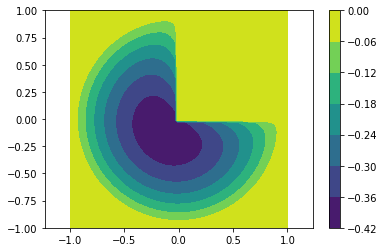

In [45]:
plt.contourf(*X,solution_Uniform); plt.axis('equal'); plt.colorbar();

It also still works on simpler cases, such as the square and convex domain.

Iteration: 1  Residue norm: 28.748715243844497
Iteration: 2  Residue norm: 1.0319420600584213
Iteration: 3  Residue norm: 0.31112485297183456
Iteration: 4  Residue norm: 0.10299744960493495
Iteration: 5  Residue norm: 0.04170849069502247
Iteration: 6  Residue norm: 0.014264747849982218
Iteration: 8  Residue norm: 0.00015659889924535264
Iteration: 10  Residue norm: 3.2738256550146616e-12
Target residue reached. Terminating.
CPU times: user 1min 4s, sys: 10.9 s, total: 1min 15s
Wall time: 19.2 s


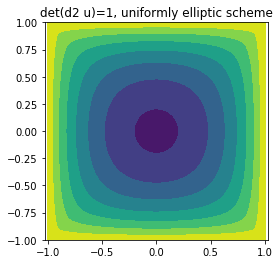

In [32]:
%%time
params = (SB0,f,bc_square)
solution_Uniform = newton_root(SchemeUniform,quadratic-2.,params) 

fig = plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title("det(d2 u)=1, uniformly elliptic scheme")
plt.contourf(*X,solution_Uniform);

Iteration: 1  Residue norm: 31.03008011084545
Iteration: 2  Residue norm: 0.9498476368044467
Iteration: 3  Residue norm: 0.2647127732107573
Iteration: 4  Residue norm: 0.0936505329236958
Iteration: 5  Residue norm: 0.03381088801041865
Iteration: 6  Residue norm: 0.008430214121142088
Iteration: 8  Residue norm: 3.2627264099360787e-06
Iteration: 9  Residue norm: 8.640377302526758e-11
Target residue reached. Terminating.
CPU times: user 58.2 s, sys: 9.66 s, total: 1min 7s
Wall time: 17.2 s


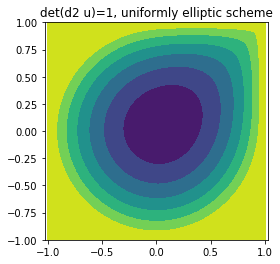

In [33]:
%%time
params = (SB0,f,bc_convex)
solution_Uniform = newton_root(SchemeUniform,quadratic-2.,params) 

fig = plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title("det(d2 u)=1, uniformly elliptic scheme")
plt.contourf(*X,solution_Uniform);

In [34]:
if figSaveDir: fig.savefig(figSaveDir+'UniformScheme_rhs=1.png')

### 3.2 Optimized implementation

We optimize the uniformly elliptic scheme using the same ingredients as for the MA-LBR scheme: the envelope theorem, and dense-sparse AD composition.

In [35]:
def SchemeUniform_OptInner(u,SB,f,bc,oracle=None):
    # Use the oracle, if available, to select the active superbases only
    if not(oracle is None):
        SB = np.take_along_axis(SB,np.broadcast_to(oracle,SB.shape[:2]+(1,)+oracle.shape),axis=2)

    d2u = bc.Diff2(u,SB) 
    d2u[...,bc.not_interior] = 0. # Placeholder value to silent NaN warnings
    
    # Generate the parameters for the low dimensional optimization problem
    Q = 0.5*np.array([[0,1,1],[1,0,1],[1,1,0]])
    dim = 2
    l = -d2u/(dim * f**(1/dim))
    m = lp.dot_VV(SB,SB)

    
    m = bc.as_field(m)
    from NumericalSchemes.FiniteDifferences import as_field
    Q = as_field(Q,m.shape[1:])
    
    # Evaluate the non-linear functional using dense-sparse composition
    result = ad.apply(ConstrainedMaximize, Q,l,m, shape_bound=u.shape)
    
    return ad.max_argmax(result,axis=0)

def SchemeUniform_Opt(u,SB,f,bc):
    
    # Evaluate the maximum over the superbases using the envelope theorem
    residue,_ = ad.apply(SchemeUniform_OptInner, u,bc.as_field(SB),f,bc, envelope=True)
    
    return ad.where(bc.interior,residue,u-bc.grid_values)

The computation time is significantly reduced with these optimizations, and we can afford to take more superbases: `SB2` instead of `SB0`.

In [36]:
%%time
params = (SB2,f,bc_convex)
solution_Uniform = newton_root(SchemeUniform_Opt,quadratic-2.,params) 

Iteration: 1  Residue norm: 21.408051019835305
Iteration: 2  Residue norm: 3.3202698007312628
Iteration: 3  Residue norm: 2.555840612527902
Iteration: 4  Residue norm: 0.4315948370167794
Iteration: 5  Residue norm: 0.1611345091458823
Iteration: 6  Residue norm: 0.01860633248562693
Iteration: 8  Residue norm: 1.8482807535136203e-05
Iteration: 9  Residue norm: 1.985543729432493e-09
Target residue reached. Terminating.
CPU times: user 19.3 s, sys: 1.24 s, total: 20.5 s
Wall time: 5.2 s


## 3 Validation

When designing and implementing a numerical method, one must distinguish:
* *Mathematical correctness*. A proof on paper that the scheme solutions exist, are unique, and e.g. do converge toward the solution of a continuous problem of interest as the grid is refined.
* *Implementation correctness*. The fact that the code faithfully reflects the mathematical description. A.k.a the absence of bugs. 

This section deals with implementation correctness. Again, there are two options:
* Computer assisted proof of correctness. This approach is still mostly sci-fy at the moment, although I would love it in principle. See [F*](https://www.fstar-lang.org/) for such works.
* A series of tests showing that the implementation obeys some expected mathematical properties. 

We rely on the second approach, and for that purpose we compare the implemented schemes between themselves, and with variants.

In [37]:
LInfNorm=ad.Optimization.norm_infinity

### 3.1 Comparison with a sampling based scheme

The scheme described above is based on a discretization of the PDE formulation
$$
    0 = \max_D \det(D)^\frac 1 d - \alpha(x) {\rm tr} (D \nabla ^2 u(x))
$$
followed with an exact solution subject to the constraints
$$
    D \succeq 0, \qquad {\rm tr} (D) = 1,
$$
and the additional constraint that some superbase $s \in SB$ is obtuse. Denote by $F_{SB}$ this scheme.

**Sampling based scheme**
For validation purposes, it can be interesting to consider a brute-force approach to the same optimization problem, based on a sampling of the parameter space. Namely
$$
    D(\mu,\theta) := R_\theta 
    \begin{pmatrix} \mu & 0 \\ 0 & 1-\mu \end{pmatrix}
    R_\theta^T
$$
where $\mu\in M_n \subset [0,1/2]$ and $\theta\in \Theta_n [0,\pi]$. Here $A_n$ and $\Theta_n$ are $n$-element regular sampling of their respective containing intervals. 

Let us denote by $F^n$ this second scheme, and by $F^n_{SB}$ the same similar scheme where one only keeps matrices $D(\mu,\theta)$ for which some superbase $s \in SB$ is obtuse.

**Convergence**
By construction, one should have as $n \to \infty$, for any discrete map $u$ and set of superbases $SB$
$$
    F_{SB}^n(u) = F_{SB}(u) + O(n^{-1}).
$$
Note that the test function $u$, and the set of superbases are here fixed.

**Similar work** A similar approach is implemented in the notebook [NonlinearMonotoneSecond2D](NonlinearMonotoneSecond2D.ipynb). In that case, the order of convergence is $O(n^{-2})$, instead of $O(n^{-1})$. The difference is related with the sampling of the boundary of the optimization domain.

In [38]:
def SchemeSampling(u,mus,thetas,SB,f,bc):
    # Sampling is independent for mu and theta
    mus=np.expand_dims(mus,axis=0)
    thetas=np.expand_dims(thetas,axis=1)

    # Build the tensors
    e=np.array(((np.cos(thetas),np.sin(thetas)),(-np.sin(thetas),np.cos(thetas))) )
    D = mus*lp.outer_self(e[0])+(1.-mus)*lp.outer_self(e[1])
    
    # Select the tensors for which one of the superbases is obtuse
    # This step is only needed if one intends to reproduce the consistent schem
    if D is not None:
        nD = np.prod(D.shape[2:]); D=D.reshape((2,2,1,1,nD))
        nSB=SB.shape[2]; SB=SB.reshape((2,3,nSB,1))
        scals = lp.dot_VAV(SB,D,np.roll(SB,axis=1,shift=1))
        # Test if a given superbase is obtuse for a given tensor
        is_obtuse = scals.max(axis=0)<=0 
        # Test if a given tensor admits an obtuse superbase among the proposed ones
        is_admissible = is_obtuse.any(axis=0)
        D=D.squeeze(axis=(2,3))
        D=D[:,:,is_admissible]
    

    # Decompose the tensors
    coefs,offsets = Selling.Decomposition(D)
    coefs = bc.as_field(coefs)
    
    # Discretization
    d=2.
    alpha = 1./(d*f**(1./d))
    d2u = bc.Diff2(u,offsets)    
    detD = bc.as_field(lp.det(D))
    res = detD**(1./d)-alpha*(coefs*d2u).sum(axis=0)
    # Note : optimization opportunity using the envelope theorem
    residue = res.max(axis=0) 
    return ad.where(bc.interior,residue,u-bc.grid_values)

In [39]:
np.random.seed(42)
u = np.random.uniform(-1,1,bc_square.shape)
bc_mock = Domain.MockDirichlet(u.shape,1.,0.)
params = (SB0,f,bc_mock)

residue_consistent = SchemeUniform(u,*params)

def error(n): 
    mus=np.linspace(0,0.5,n,endpoint=False)+0.25/n
    thetas=np.linspace(0,np.pi,n,endpoint=False)
    residue_sampling = SchemeSampling(u,mus,thetas,*params)

    LInfNorm=ad.Optimization.norm_infinity
    residue_diff = residue_sampling-residue_consistent
    return LInfNorm(residue_sampling-residue_consistent)

In [40]:
samples = [5,8,12,16,20,25,30,35,40] #,50,60,70,80,100]
errors = [error(n) for n in samples]

The sampling based scheme does converge toward the consistent scheme, with the expected convergence order $O(n^{-1})$.

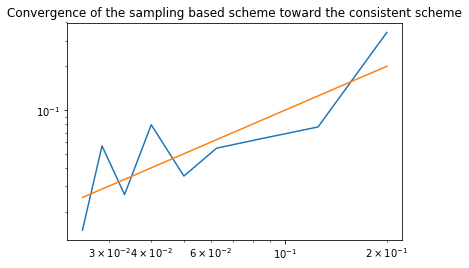

In [41]:
isamples=1./np.array(samples); plt.title("Convergence of the sampling based scheme toward the consistent scheme")
plt.loglog(isamples,errors, isamples,isamples);

### 3.2 The monotone and consistent schemes have identical solutions

The implementation of the MALBR scheme and of the Uniformly elliptic schemes are quite different. 
However, it can be shown that a solution to the first scheme is a solution to the second scheme, and conversely.

This is not a convergence result as a grid is refined. It is a result valid at any fixed scheme, up to machine precision due to rounding errors. Note also that the scheme residues are in general different if they are non-zero.

In [42]:
params = (SB2,f,bc_convex)
solution_Uniform = newton_root(SchemeUniform_Opt,quadratic-2.,params) 

Iteration: 1  Residue norm: 21.408051019835305
Iteration: 2  Residue norm: 3.3202698007312628
Iteration: 3  Residue norm: 2.555840612527902
Iteration: 4  Residue norm: 0.4315948370167794
Iteration: 5  Residue norm: 0.1611345091458823
Iteration: 6  Residue norm: 0.01860633248562693
Iteration: 8  Residue norm: 1.8482807535136203e-05
Iteration: 9  Residue norm: 1.985543729432493e-09
Target residue reached. Terminating.


In [43]:
LInfNorm(SchemeMALBR_Opt(solution_Uniform,*params))

6.262594354211615e-08